In [7]:
import pandas as pd
import os

# train = pd.read_csv("train-no-tma.csv")
val = pd.read_csv("data/train.csv")
# val = pd.read_csv("train-yes-tma.csv")
# val = val[~val['image_id'].isin(train['image_id'])]

def get_image_path(image_id:int, directory:str):
    return os.path.join(directory, str(image_id))

val['tile_path_0'] = val['image_id'].apply(lambda x: get_image_path(x, 'tiles'))
val['tile_path_1'] = val['image_id'].apply(lambda x: get_image_path(x, 'tiles_2964'))
val.head()

,image_id,label,image_width,image_height,is_tma,tile_path_0,tile_path_1
0,4,HGSC,23785,20008,False,tiles/4,tiles_2964/4
1,66,LGSC,48871,48195,False,tiles/66,tiles_2964/66
2,91,HGSC,3388,3388,True,tiles/91,tiles_2964/91
3,281,LGSC,42309,15545,False,tiles/281,tiles_2964/281
4,286,EC,37204,30020,False,tiles/286,tiles_2964/286


In [8]:
from PIL import Image
import torch
import torch.nn as nn
from transformers import ViTImageProcessor, ViTForImageClassification

N_MODELS = 2

device = "cpu"
model_name = "google/vit-base-patch16-224"
print(f"Using device {device} and model {model_name}")
# epoch = 261
# step = 16750
# epoch = 780
# step = 50000
epoch = 294
step = 20000

processor = ViTImageProcessor.from_pretrained(model_name)
models = [ViTForImageClassification.from_pretrained(model_name) for _ in range(N_MODELS)]
classifier = nn.Linear(models[0].classifier.in_features * N_MODELS, 5)
for i_model, model in enumerate(models):
    model.classifier = nn.Identity()
    model = model.to(device)

    state_dict = torch.load(f'vit-finetune-big-and-small-models-pt-5/model_{i_model}_epoch_{epoch}_step_{step}.pth', map_location=device)
    model.load_state_dict(state_dict)

state_dict = torch.load(f'vit-finetune-big-and-small-models-pt-5/classifier_epoch_{epoch}_step_{step}.pth', map_location=device)
classifier.load_state_dict(state_dict)

Using device cpu and model google/vit-base-patch16-224


<All keys matched successfully>

In [9]:
integer_to_label = {
    0: 'HGSC',
    1: 'CC',
    2: 'EC',
    3: 'LGSC',
    4: 'MC',
}

label_to_integer = {
    'HGSC': 0,
    'CC': 1,
    'EC': 2,
    'LGSC': 3,
    'MC': 4,
}

In [10]:
import os
from PIL import Image, ImageFile
import torch
import pandas as pd
import torchvision.transforms as transforms
import random
import math
import numpy as np
from scipy.stats import entropy

def process_sub_images(path, i_model):
    # Get all .png files from the directory
    all_files = [f for f in os.listdir(path) if f.lower().endswith('.png')]
    
    # Randomly select files
    sample_size = min(3, len(all_files))
    sampled_files = random.sample(all_files, sample_size)
    
    combined_vector = torch.zeros([768])

    for image_name in sampled_files:
        image_path = os.path.join(path, image_name)
        sub_image = Image.open(image_path)
        
        inputs = processor(images=sub_image, return_tensors="pt")
        for key in inputs.keys():
            inputs[key] = inputs[key].to(device)

        outputs = models[i_model](**inputs)
        combined_vector += outputs.logits[0]

    return combined_vector / sample_size


# Sort the dataframe by 'label' to ensure the order of categories.
sorted_val = val.sort_values('label')

# This will keep track of the indexes for each label type as you iterate through them.
label_indices = {label: iter(rows.index) for label, rows in sorted_val.groupby('label')}

total = 0
total_correct = 0
done = False

all_vectors = []
classes = []

for model in models:
    model.eval()
classifier.eval()
while not done:
    for label in ['HGSC', 'CC', 'EC', 'LGSC', 'MC']:
        try:
            # Try to get the next index for the current label
            index = next(label_indices[label])
            row = sorted_val.loc[index]
            vectors = []
            for i_model in range(N_MODELS):
                vectors.append(process_sub_images(row[f'tile_path_{i_model}'], i_model))
            
            classifier_input = torch.cat(vectors, dim=0)
            classifier_output = classifier(classifier_input)
            probs = classifier_output.softmax(dim=0)
            
            predicted_label = integer_to_label[probs.argmax(dim=0).item()]
            is_correct = predicted_label == row.label
            total_correct += is_correct
            total += 1
            
            
            # all_vectors.append(classifier_input)
            # classes.append(predicted_label)
            print(f"{total} Image ID: {row['image_id']} True Label: {row.label} Correct? {is_correct} Accuracy: {total_correct / total:.3f} Probability: {probs[probs.argmax(dim=0).item()].item():.3f}")
        except StopIteration:
            # If there are no more items in the current label, break out of the loop.
            done = True
            break



# for _, row in val.iterrows():
    
#     vectors = []
#     for i_model in range(N_MODELS):
#         vectors.append(process_sub_images(row[f'tile_path_{i_model}'], i_model))

#     classifier_input = torch.cat(vectors, dim=0)
#     classifier_output = classifier(classifier_input)
#     probs = classifier_output.softmax(dim=0)

#     predicted_label = integer_to_label[probs.argmax(dim=0).item()]
#     is_correct = predicted_label == row.label
#     total_correct += is_correct
#     total += 1
    
#     all_vectors.append(classifier_input)
#     classes.append(predicted_label)
#     print(f"{total} Image ID: {row['image_id']} True Label: {row.label} Correct? {is_correct} Accuracy: {total_correct / total:.3f} Probability: {probs[probs.argmax(dim=0).item()].item():.3f}")

1 Image ID: 38097 True Label: HGSC Correct? False Accuracy: 0.000 Probability: 0.776
2 Image ID: 43796 True Label: CC Correct? True Accuracy: 0.500 Probability: 0.996
3 Image ID: 44962 True Label: EC Correct? True Accuracy: 0.667 Probability: 0.785
4 Image ID: 3672 True Label: LGSC Correct? True Accuracy: 0.750 Probability: 0.997
5 Image ID: 36783 True Label: MC Correct? True Accuracy: 0.800 Probability: 0.994
6 Image ID: 38535 True Label: HGSC Correct? False Accuracy: 0.667 Probability: 0.687
7 Image ID: 48506 True Label: CC Correct? True Accuracy: 0.714 Probability: 0.996
8 Image ID: 28736 True Label: EC Correct? False Accuracy: 0.625 Probability: 0.377
9 Image ID: 56500 True Label: LGSC Correct? True Accuracy: 0.667 Probability: 0.861
10 Image ID: 3997 True Label: MC Correct? True Accuracy: 0.700 Probability: 0.967
11 Image ID: 40639 True Label: HGSC Correct? True Accuracy: 0.727 Probability: 0.374
12 Image ID: 10548 True Label: CC Correct? True Accuracy: 0.750 Probability: 0.764
13

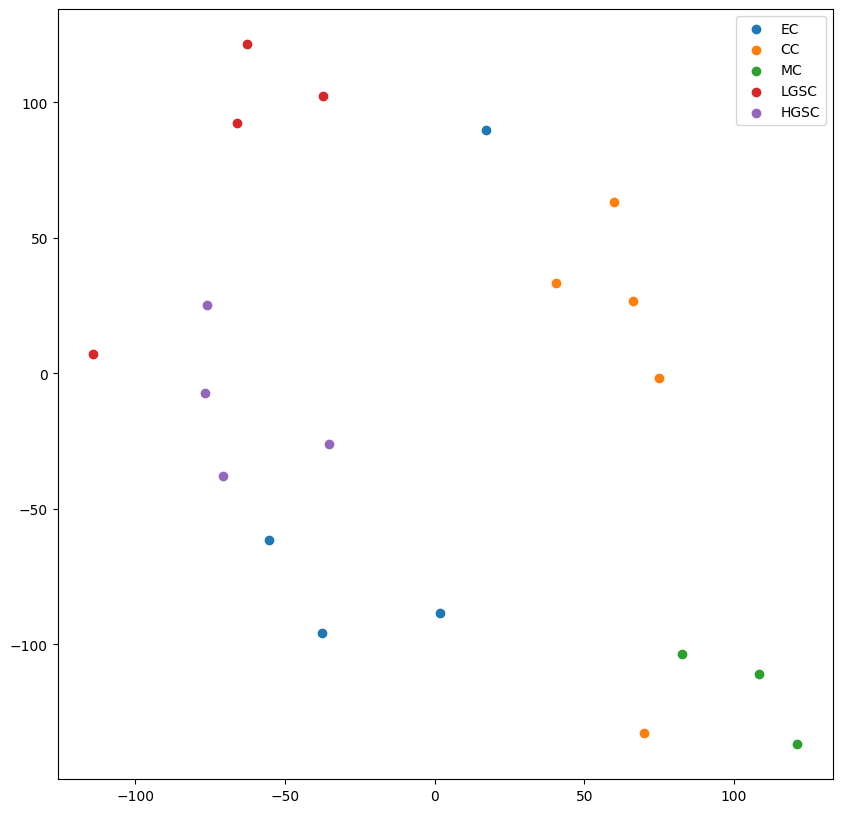

In [171]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tensor_stack = torch.stack(all_vectors)

tsne = TSNE(n_components=2, random_state=0, perplexity=5)
vectors_2d = tsne.fit_transform(tensor_stack.detach().numpy())

plt.figure(figsize=(10, 10))
for i, label in enumerate(set(classes)):
    indices = [j for j, x in enumerate(classes) if x == label]
    plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1], label=label)

plt.legend()
plt.show()
